## Testing Intrinsic Electrophysiological Properties

In [2]:
%matplotlib notebook
import brian2 as b2
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import datetime

from input_factory import get_step_current, get_ou_current
from plot_tools import plot_voltage_and_current_traces

### Neuron models
GLIF5 of [Teeter et al (2018)](https://www.nature.com/articles/s41467-017-02717-4) is identical to (IF2 + dyn) of [Pozzorini et al (2015)](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004275) as also used in [Setareh et al (2017)](https://www.frontiersin.org/articles/10.3389/fncom.2017.00052/full). The model used is a Generalised (Leaky) Integrate and Fire point neuron model with a spike triggered adaptation factor (can be made with adaptation 'current' or with 'conductance') and a dynamic threshold for frequency adaptation. The spike triggered adaptation factor can be changed to IF2 or IF1 in case of FS/NFS/exc according to [Avermann et al (2012)](https://www.physiology.org/doi/abs/10.1152/jn.00917.2011), which we will see.

The subthreshold membrane potential ($V(t)$) is given by : 
$$
C \frac{dV(t)}{dt} = -g_{L}(V(t) - V_{rest}) - \sum_{\widehat{t}_{j} < t}\eta(t - \widehat{t}_{j}) + I(t)
$$

Each time a spike is emitted, an intrinsic current of the shape $\eta(t)$ is triggered, and we generally assume it to be a sum of decaying exponentials of the form $\eta^{0}e^{-\frac{t}{\tau}}$.

Stochasticity in the spike production is captured in the point process with the firing intensity
$$
\lambda(t) = \lambda_{0}exp\left(\frac{V(t) - V_{T}(t)}{\Delta V}\right)
$$

where $\lambda_{0}$ is the stochastic intensity at the time-dependent firing threshold $V_{T}$, defined by $V_{T}(t) = V_{T}^{*} + \sum_{\widehat{t}_{j} < t}\gamma(t - \widehat{t}_{j})$, where $V_{T}^{*}$ is a constant and $\gamma(t)$ describes the stereotypical time course of firing threshold after an action potential (also modeled with sums of exponential decays $\gamma^{0}e^{-\frac{t}{\tau}}$.

In [3]:
model_eqs = '''
dv/dt = (-gL*(v-v_rest) - w1 - w2 + I_ext(t))/C : volt

dw1/dt = -w1/tau_w1 : amp
dw2/dt = -w2/tau_w2 : amp

dvt1/dt = -vt1/tau_vt1 : volt
dvt2/dt = -vt2/tau_vt2 : volt

vt = v_thresh + vt1 + vt2 : volt
lambda_t = lambda_0*exp((v-vt)/del_v): Hz
'''
reset_eqs = '''
v = v_reset
w1+=amp_w1
w2+=amp_w2
vt1+=amp_vt1
vt2+=amp_vt2
'''

In [4]:
exc_df = pd.read_csv('data/exc.txt',header = None)
exc_df.columns =['C (nF)','gL (usiemens)','v_rest (mV)','v_reset (mV)','tau_refr (ms)',\
             'v_thresh (mV)','del_v (mV)', 'amp_w1 (nA)','tau_w1 (ms)','amp_w2 (nA)',\
             'tau_w2 (ms)','amp_vt1 (mV)','tau_vt1 (ms)','amp_vt2 (mV)','tau_vt2 (ms)']

In [5]:
exc_df

,C (nF),gL (usiemens),v_rest (mV),v_reset (mV),tau_refr (ms),v_thresh (mV),del_v (mV),amp_w1 (nA),tau_w1 (ms),amp_w2 (nA),tau_w2 (ms),amp_vt1 (mV),tau_vt1 (ms),amp_vt2 (mV),tau_vt2 (ms)
0,0.052605,0.006332,-65.712,-28.444,4,-51.277,1.7330,0.282820,84.692,-0.267290,90.124,12.198,31.706,1.4937,583.34
1,0.083088,0.003702,-67.004,-36.738,4,-39.600,1.3919,0.056698,57.829,-0.006954,218.160,11.702,53.831,1.7710,639.99
2,0.049219,0.005441,-75.799,-37.593,4,-59.219,2.0347,0.067924,41.671,0.002965,700.000,16.663,23.688,1.4191,448.35
3,0.076756,0.002304,-69.927,-34.747,4,-57.404,1.7679,0.087438,44.936,0.001879,700.000,13.716,42.159,1.7180,644.97
4,0.052735,0.008606,-67.827,-39.373,4,-61.676,1.9271,0.257410,98.000,-0.250320,102.330,11.329,26.534,2.2938,497.07
5,0.062974,0.008105,-58.588,-31.940,4,-55.977,1.7631,0.036344,39.221,0.000689,700.000,13.033,45.009,2.5180,476.50
6,0.085818,0.007091,-71.982,-36.894,4,-56.006,1.4662,0.804900,117.150,-0.764430,122.450,11.704,43.722,1.5141,1501.60


In [18]:
exc_df.iloc[1,:][0]/exc_df.iloc[1,:][1]

22.442871805953217

In [5]:
exc_param = exc_df.iloc[1,:] #set which value to try out, set any if running through all

lambda_0 = 10 * b2.kHz

C = exc_param['C (nF)'] * b2.nF
gL = exc_param['gL (usiemens)'] * b2.usiemens
v_rest = exc_param['v_rest (mV)'] * b2.mV
v_reset = exc_param['v_reset (mV)'] * b2.mV
tau_refr = exc_param['tau_refr (ms)'] * b2.ms

v_thresh = exc_param['v_thresh (mV)'] * b2.mV
# del_v = exc_param['del_v (mV)'] * b2.mV
del_v = 0.1 * b2.mV
amp_w1 = exc_param['amp_w1 (nA)'] * b2.nA
tau_w1 = exc_param['tau_w1 (ms)'] * b2.ms
amp_w2 = exc_param['amp_w2 (nA)'] * b2.nA
tau_w2 = exc_param['tau_w2 (ms)'] * b2.ms

amp_vt1 = exc_param['amp_vt1 (mV)'] * b2.mV
tau_vt1 = exc_param['tau_vt1 (ms)'] * b2.ms
amp_vt2 = exc_param['amp_vt2 (mV)'] * b2.mV
tau_vt2 = exc_param['tau_vt2 (ms)'] * b2.ms

In [6]:
## amplitude to be played with 
# I_ext = get_step_current(t_start =100, t_end = 700, unit_time = 1*b2.ms, amplitude = 0.2*b2.namp)
I_ext = get_ou_current(10)
time = 1000 * b2.ms

EXC = b2.NeuronGroup(1, model = model_eqs, reset = reset_eqs, threshold = "rand() < lambda_t*dt",refractory = tau_refr, method = 'rk4')
EXC.v = v_rest
EXC.vt1 = 0 * b2.mV
EXC.vt2 = 0 * b2.mV
EXC.w1 = EXC.w2 = 0*b2.nA

voltage_monitor = b2.StateMonitor(EXC, ['v','vt','w1','w2'], record=True)
spike_monitor = b2.SpikeMonitor(EXC, variables = ["v"])

print("Before simulation" , datetime.datetime.now())

b2.run(time)

print("After simulation" , datetime.datetime.now())

Before simulation 2018-07-19 11:49:38.311933
After simulation 2018-07-19 11:49:50.668110


<IPython.core.display.Javascript object>


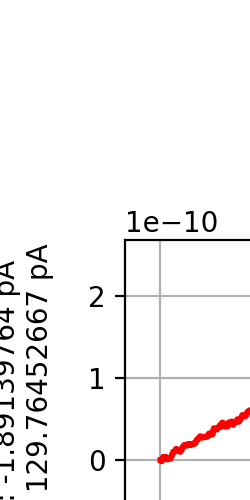

In [7]:
fig = plt.figure(figsize=(5,10))
plot_voltage_and_current_traces(voltage_monitor, spike_monitor, I_ext)
plt.show()


In [9]:
fig.savefig('../figs/ou_all_exc.jpg')